# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import pandas as pd
import matplotlib.pyplot as plt
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics, CRF

model = spacy.load("en_core_web_sm")

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1871 sha256=b9ea3b20e089e6bfc893c852e1214ce835131cfad1481e6f945da7ebf313ef06
  Stored in directory: /root/.cache/pip/wheels/e3/d2/c9/ba15b05ba596e2eafeb83c2903e79d634207367555aae8c7d2
Successfully built pycrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

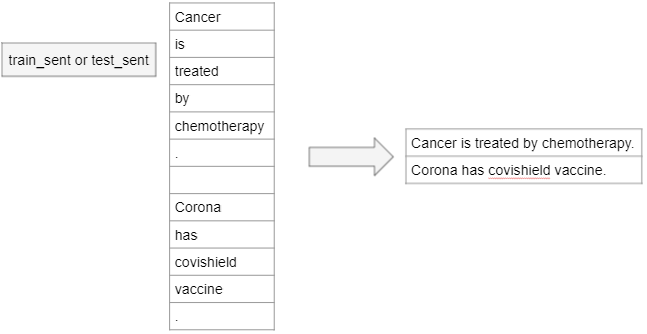

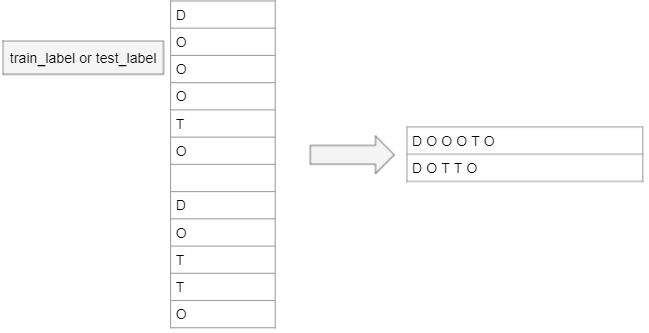

In [ ]:
# This function extracts sentences from the given file based on the separator.
def extract_sentences_from_file(filepath='',sep=' '):
    try:
        with open (filepath,'r',encoding='utf-8') as file_text:
            if file_text.mode  == 'r':
                file_content = file_text.readlines()
        sentences = []
        each_sentence=''
        for char in file_content:
            # stripping end of line char
            content_word = char.strip('\n')
            if content_word == '':
                # Line break found. Append the sentence to the sentence list
                sentences.append(each_sentence.strip(' '))
                each_sentence=''
            else:
                # forming sentence
                each_sentence += content_word + ' '

        print('Total number of sentences: ',len(sentences),'\n')
        print('*'*50)
        print('Top 5 sentences in the sentences list:\n',sentences[:5])
        return sentences
    except FileNotFoundError:
        print('File not found.')

### Count the number of sentences in the processed train and test dataset

In [ ]:
# Creating and getting the count of sentences in TRAIN Dataset
train_sent = extract_sentences_from_file(filepath='train_sent',sep='\n')

# Also printing first five records

Total number of sentences:  2599 

**************************************************
Top 5 sentences in the sentences list:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]


In [ ]:
# Creating and getting the count of sentences in TEST Dataset
test_sent = extract_sentences_from_file(filepath='test_sent',sep='\n')

Total number of sentences:  1056 

**************************************************
Top 5 sentences in the sentences list:
 ['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']


### Count the number of lines of labels in the processed train and test dataset.

In [ ]:
# Creating and getting the count of number of lines of labels in TRAIN Dataset
train_label = extract_sentences_from_file(filepath='train_label',sep='\n')

Total number of sentences:  2599 

**************************************************
Top 5 sentences in the sentences list:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O']


In [ ]:
# Creating and getting the count of number of lines of labels in TEST Dataset
test_label = extract_sentences_from_file(filepath='test_label',sep='\n')

Total number of sentences:  1056 

**************************************************
Top 5 sentences in the sentences list:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O']


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [ ]:
# Creating empty Train and Test dataframes for POS, Lemma tagging along with Labels
train_df = pd.DataFrame(columns=['SENTENCE','WORD','POS','LEMMA','LABEL'])
test_df = pd.DataFrame(columns=['SENTENCE','WORD','POS','LEMMA','LABEL'])

In [ ]:
# Tokenizing Train datframe

nlp= spacy.load("en_core_web_sm")

i=0
j=0
# for each sentence
for sent, label in zip(train_sent, train_label):
    i+=1
    # for each word in a sentence
    for word, lbl in zip(sent.split(), label.split()):
        doc = nlp(word)
        for tokn in doc:
            train_df.loc[j,['SENTENCE','WORD','POS','LEMMA','LABEL']] = [i,tokn.text,tokn.pos_,tokn.lemma_,lbl]
            j+=1

In [ ]:
# Tokenizing Test datframe

i=0
j=0
# for each sentence
for sent, label in zip(test_sent, test_label):
    i+=1
    # for each word in a sentence
    for word,lbl in zip(sent.split(),label.split()):
        doc = nlp(word)
        for tokn in doc:
            test_df.loc[j,['SENTENCE','WORD','POS','LEMMA','LABEL']] = [i,tokn.text,tokn.pos_,tokn.lemma_,lbl]
            j+=1

In [ ]:
# Concatenating TRAIN and TEST dataframes to find the top 25 most common tokens
data_df = pd.concat((train_df,test_df),axis=0)
# Resetting index
data_df.reset_index(inplace=True,drop=True)

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [ ]:
top_25 = data_df[(data_df['POS'] == 'NOUN') | ((data_df['POS'] == 'PROPN'))]['WORD'].value_counts()[:25]
top_25

,count
WORD,
patients,492
treatment,281
cancer,200
therapy,175
study,162
disease,143
cell,140
lung,116
group,94


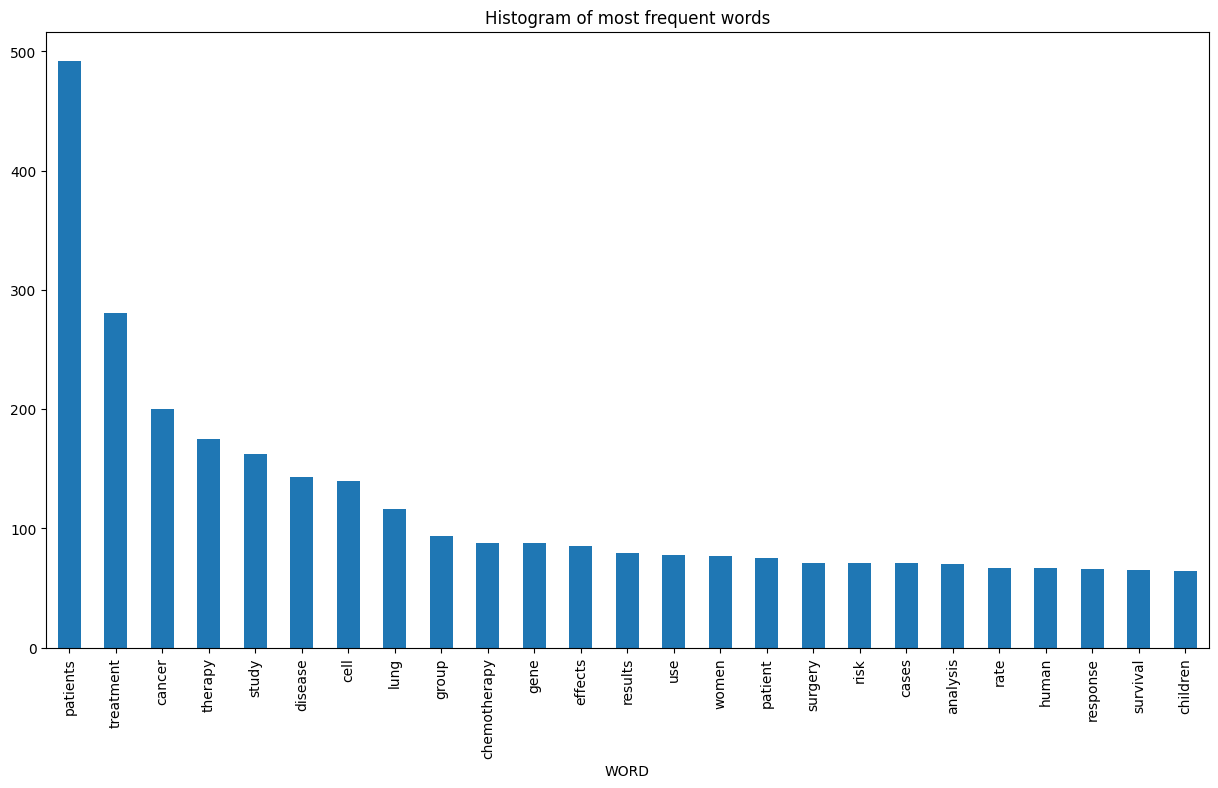

In [ ]:
# plotting most frequent words for EDA
plt.figure(figsize=(15,8))
ax = top_25.plot.bar()
ax.set_title('Histogram of most frequent words')
plt.show()

In [ ]:
 # Print the top 25 most common LEMMA words with NOUN and Proper noun POS tags
top_25_lemma = data_df[(data_df['POS'] == 'NOUN') | ((data_df['POS'] == 'PROPN'))]['LEMMA'].value_counts()[:25]
top_25_lemma

,count
LEMMA,
patient,587
treatment,316
study,227
cancer,226
cell,203
therapy,182
effect,182
disease,172
case,131


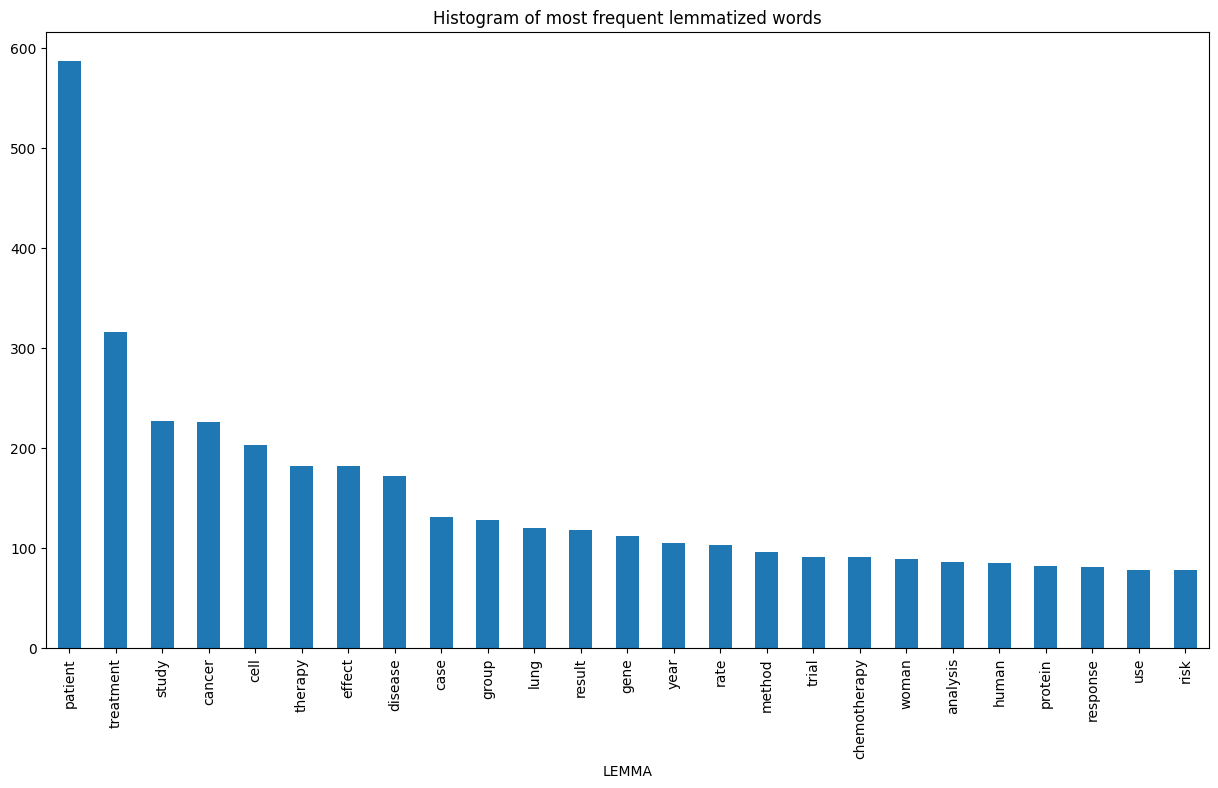

In [ ]:
# plotting most frequent words for EDA
plt.figure(figsize=(15,8))
ax = top_25_lemma.plot.bar()
ax.set_title('Histogram of most frequent lemmatized words')
plt.show()

### OBSERVATION:
- From both the graphs looks like the data is mostly for cancer and chemotherapy, followed by surgery are the most sought after Treatment
- The data also shows diseases mostly in women followed by children
- Most common organ affected is lungs

In [ ]:
# Train dataframe with tokens
train_df.head()

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,All,ADV,all,O
1,1,live,ADJ,live,O
2,1,births,NOUN,birth,O
3,1,>,PUNCT,>,O
4,1,or,CCONJ,or,O


In [ ]:
# Test dataframe with tokens
test_df.head()

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,Furthermore,ADV,furthermore,O
1,1,",",PUNCT,",",O
2,1,when,SCONJ,when,O
3,1,all,PRON,all,O
4,1,deliveries,NOUN,delivery,O


## Defining features for CRF





In [ ]:
# Let's define the features to get the feature value for one word.

def getFeatures_For_OneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # id for the word
    'word[-2:]=' + word[-2:],     # last 2 characters
    'word[-3:]=' + word[-3:],     # last 3 characters
    'word.isupper=%s' % word.isupper(),  # is uppercase
    'word.isdigit=%s' % word.isdigit(),  # is number
    'word.startsWithCapital=%s' % word[0].isupper(), # starts with Capital
    'word.pos=' + pos_tags[pos], # pos tag
    'word.pos_isnoun=%s' % (pos_tags[pos] in ['NOUN','PROPN'])
  ]

  # previous word features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1],
    'prev_word.pos_isnoun=%s' % (pos_tags[pos] in ['NOUN','PROPN'])
  ])
  # marking beginning and end of sentences
  else:
    features.append('BEG') # feature for beginning of sentence

  if(pos == len(sentence)-1):
    features.append('END') # feature for end of sentence

  return features


## Getting the features

### Write a code/function to get the features for a sentence

In [ ]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    tokenized_sentence = nlp(sentence)
    postags = []

    for each_tokn in tokenized_sentence:
        postags.append(each_tokn.pos_)

    sentence_list = sentence.split()
    return [getFeatures_For_OneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]


### Write a code/function to get the labels of a sentence

In [ ]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [ ]:
# Apply function 'getFeaturesForOneSentence' to get features for first sentence in train_sentences
example_sentence = train_sent[0]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)

# checking if features are extracted correctly for 3rd word in first sentence of train dataset
features[2]

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


['word.lower=births',
 'word[-2:]=hs',
 'word[-3:]=ths',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=NOUN',
 'word.pos_isnoun=True',
 'prev_word.lower=live',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'prev_word.pos_isnoun=True']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [ ]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

In [ ]:
# checking X_train and X_test
print(X_train[0][:3])
print(X_test[0][:3])

[['word.lower=all', 'word[-2:]=ll', 'word[-3:]=All', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=DET', 'word.pos_isnoun=False', 'BEG'], ['word.lower=live', 'word[-2:]=ve', 'word[-3:]=ive', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=ADJ', 'word.pos_isnoun=False', 'prev_word.lower=all', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=True', 'prev_word.pos=DET', 'prev_word.pos_isnoun=False'], ['word.lower=births', 'word[-2:]=hs', 'word[-3:]=ths', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=NOUN', 'word.pos_isnoun=True', 'prev_word.lower=live', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False', 'prev_word.pos=ADJ', 'prev_word.pos_isnoun=True']]
[['word.lower=furthermore', 'word[-2:]=re', 'word[-3:]=ore', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=ADV'

### Define the labels as the target variable for test and the train dataset

In [ ]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

In [ ]:
# checking Y_train and Y_test
print(Y_train[0][:3])
print(Y_test[0][:3])

['O', 'O', 'O']
['O', 'O', 'O']


## Build the CRF Model

In [ ]:
# Building the CRF model with max iteration 100
# Regularization terma c1 and c2 are chosen as 1.0 and 0.01 after many experimentation for the best results based on F1 score
crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)

# fit the model
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
Y_pred = crf.predict(X_test)


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
# Calculate the f1 score using the test data
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('F1-score for Medical NER Dataset : {0} % '.format(round(f1_score*100,2)))

F1-score for Medical NER Dataset : 91.43 % 


In [ ]:
# Calculate the f1 score using the test data
precision = metrics.flat_precision_score(Y_test, Y_pred, average='weighted')
recall  = metrics.flat_recall_score(Y_test, Y_pred, average='weighted')
accuracy = metrics.flat_accuracy_score(Y_test, Y_pred)
print('Precision score for Medical NER Dataset : {0} % '.format(round(precision*100,2)))
print('Recall score for Medical NER Dataset : {0} % '.format(round(recall*100,2)))
print('Accuracy score for Medical NER Dataset : {0} % '.format(round(accuracy*100,2)))

Precision score for Medical NER Dataset : 91.36 % 
Recall score for Medical NER Dataset : 92.01 % 
Accuracy score for Medical NER Dataset : 92.01 % 


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

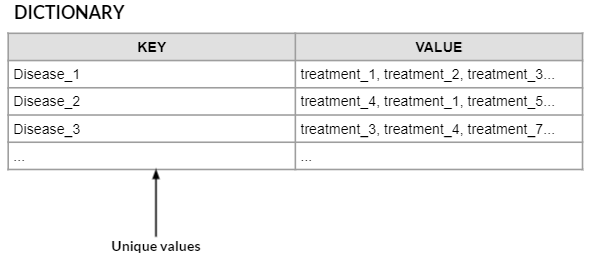

In [ ]:
print(Y_pred)

[list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])
 list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])
 list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])
 ... list(['T', 'T', 'T', 'T', 'T', 'T', 'O', 'D', 'D', 'D'])
 list(['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D'])
 list(['O', 'O', 'O', 'O', 'O', 'O', 'O'])]


In [ ]:
# Creating dictionary for the diseases and recommended Treatments for the same
DiseaseTreatment_dict = dict()

for i in range(len(Y_pred)):

    # tag of each sentence as per prediction
    DTO_tag = Y_pred[i]
    Diseases = ""
    Treatments = ""

    # Iterating over DTO tag of each word in a sentence
    # to obtain Disease and Treatment from it
    for j in range(len(DTO_tag)):
        if DTO_tag[j] == 'D': # for obtaining Disease
            Diseases += test_sent[i].split()[j] + " "
        elif DTO_tag[j] == 'T': # for obtaining Treatment
            Treatments += test_sent[i].split()[j] + " "

    # Removing extra white space
    Diseases = Diseases.lstrip().rstrip()
    Treatments = Treatments.lstrip().rstrip()

    # Adding Disease and Treatments to dictionary
    if Diseases != "" and Treatments != "":
        if Diseases in DiseaseTreatment_dict.keys(): # disease key already present
            treatment_out = list([Diseases])
            treatment_out.append(Treatments)   # append treatment
            DiseaseTreatment_dict[Diseases] = treatment_out
        elif Diseases not in DiseaseTreatment_dict.keys(): # adding disease and treatment if not present in dictionary
            DiseaseTreatment_dict[Diseases] = Treatments

In [ ]:
# lets view some records from Dictionary
Disease_Treatment_df = pd.DataFrame(columns=['Diseases','Treatment'])
i = 0
for k, v in DiseaseTreatment_dict.items():
  l = [k, v]
  Disease_Treatment_df.loc[len(Disease_Treatment_df.index)] = l
Disease_Treatment_df.head(5)

,Diseases,Treatment
0,gestational diabetes,good glycemic control
1,hereditary retinoblastoma,radiotherapy
2,epilepsy,Methylphenidate
3,unstable angina or non-Q-wave myocardial infar...,roxithromycin
4,coronary-artery disease,Antichlamydial antibiotics


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
disease = 'hereditary retinoblastoma'
print("Treatment for Disease '"+ disease+ "' is '"+ DiseaseTreatment_dict[disease]+"'")

Treatment for Disease 'hereditary retinoblastoma' is 'radiotherapy'
